In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

# Torch Examples

In [2]:
x = Variable(torch.randn(1,3))
y = Variable(torch.randn(1,3))

# Neural Network Examples

In [2]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 convolutions
        #kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        # Max pooling over a (2x2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        
        # If the size is square, you can only specify single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [85]:
net = Net()

In [86]:
input = Variable(torch.randn(1, 1, 32, 32))
out = net(input)
print(out)

Variable containing:
-0.0123  0.0908  0.0381 -0.1028 -0.0181  0.0899 -0.0392 -0.0769  0.0525  0.0496
[torch.FloatTensor of size 1x10]



In [87]:
net.zero_grad()
out.backward(torch.randn(1,10))

In [88]:
output = net(input)
target = Variable(torch.arange(1,11))
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

Variable containing:
 38.4242
[torch.FloatTensor of size 1]



In [89]:
print(loss.grad_fn) # MSE Loss
print(loss.grad_fn.next_functions[0][0]) # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0]) # ReLu

In [90]:
net.zero_grad()

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
Variable containing:
 0
 0
 0
 0
 0
 0
[torch.FloatTensor of size 6]

conv1.bias.grad after backward
Variable containing:
1.00000e-02 *
  2.8965
 -0.4734
  1.1574
  3.9367
  2.4655
 -0.2138
[torch.FloatTensor of size 6]



In [114]:
import torch.optim as optim

# Create optimizer
optimizer = optim.SGD(net.parameters(), lr = 0.01)

# In your training loop
print('conv1.bias before updates')
print(net.conv1.bias)

optimizer.zero_grad()
output = net(input)
loss = criterion(output, target)
loss.backward()

print('conv1.bias before updates')
print(net.conv1.bias)

optimizer.step() # Does update

print('conv1.bias after updates')
print(net.conv1.bias)

conv1.bias before updates
Parameter containing:
-0.0584
-0.0275
 0.0007
 0.1984
 0.0064
-0.0953
[torch.FloatTensor of size 6]

conv1.bias before updates
Parameter containing:
-0.0584
-0.0275
 0.0007
 0.1984
 0.0064
-0.0953
[torch.FloatTensor of size 6]

conv1.bias after updates
Parameter containing:
-0.0497
-0.0227
 0.0033
 0.1989
 0.0095
-0.0939
[torch.FloatTensor of size 6]



In [112]:
optimizer.zero_grad

<bound method Optimizer.zero_grad of <torch.optim.sgd.SGD object at 0x7f376040d5f8>>

# Data Load & Transform

In [8]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [9]:
from torchvision import transforms, utils, datasets

In [19]:
img_details = pd.read_csv('/user/img_details.csv')

label_groups = img_details['Finding Labels'].unique()
labels = set([label for sublist in label_groups.tolist() for label in sublist.split('|')])
label_to_index = {idx: val for idx, val in enumerate(labels)}
label_list = list(label_to_index.values())
label_list

['Fibrosis',
 'Atelectasis',
 'No Finding',
 'Pneumonia',
 'Infiltration',
 'Edema',
 'Pneumothorax',
 'Cardiomegaly',
 'Emphysema',
 'Consolidation',
 'Effusion',
 'Nodule',
 'Mass',
 'Pleural_Thickening',
 'Hernia']

In [5]:
img_details.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN


In [57]:
mlb = MultiLabelBinarizer()
m = mlb.fit(label_groups
m.classes_

AttributeError: 'numpy.ndarray' object has no attribute 'apply'

In [36]:
img_details[img_details['Image Index'] == '00000001_002.png']['Finding Labels'].values[0]

'Cardiomegaly|Effusion'

In [12]:
#plt.imshow('/user/images/images/00000971_002.png')
#plt.imshow('/user/images/images/00001075_024.png')
#plt.imshow('/user/images/images/00001006_000.png')
#plt.imshow('/user/images/images/00000623_000.png')
#plt.imshow('/user/images/images/00000442_002.png')
#plt.imshow('/user/images/images/00001101_008.png')
#plt.imshow('/user/images/images/00000181_023.png')
#plt.imshow('/user/images/images/00000523_000.png')

In [17]:
xray_dataset = datasets.ImageFolder(root='/user/images')

In [23]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    #plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated


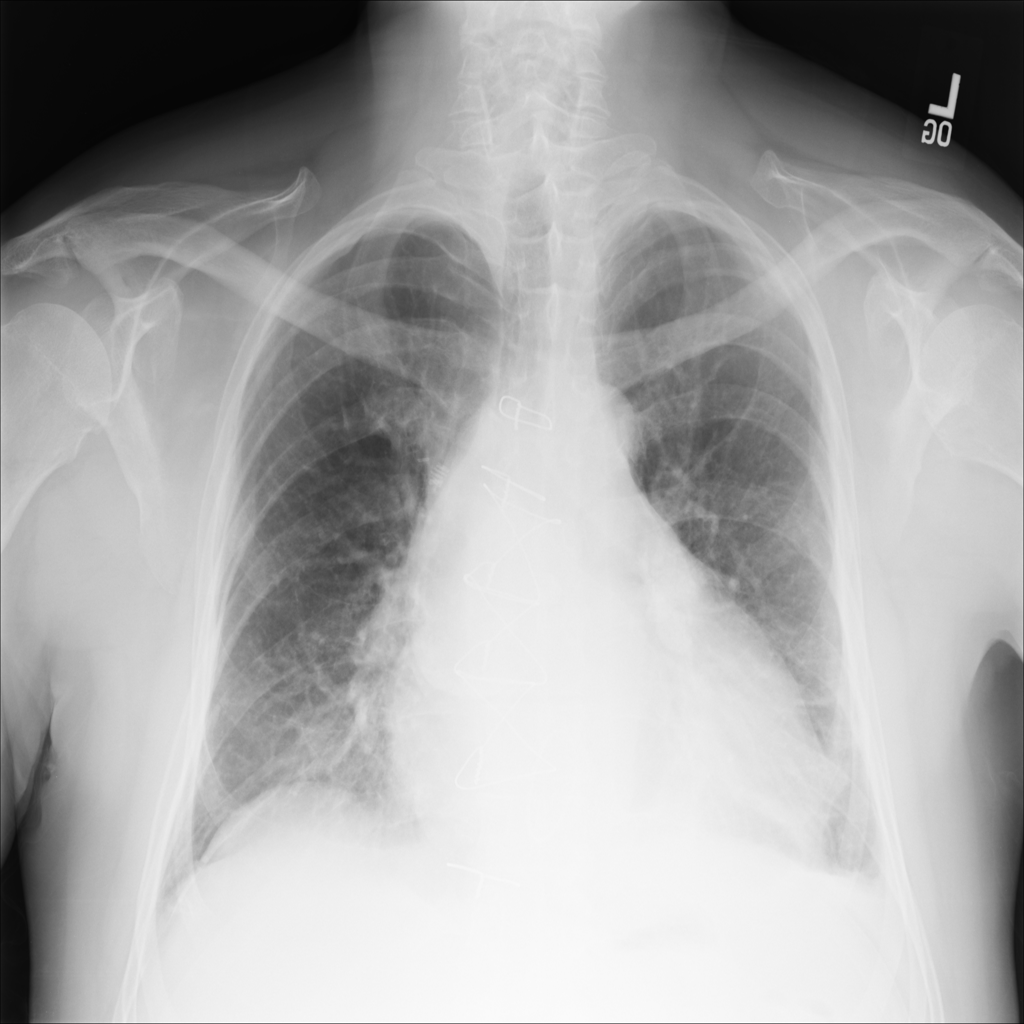

In [39]:
x = xray_dataset[2][0]
x

In [ ]:
x.getbands()

In [26]:
def create_multilabel_binarizer(label_df):
    """
    Args:
        label_df: dataframe with labels in columns 'Finding Labels'
    Returns:
        mlb: MultiLabelBinarizer to convert labels to 
    """
    splitter = lambda labels: labels.split('|')
    split_label_df = label_df['Finding Labels'].apply(splitter)
    mlb = MultiLabelBinarizer()
    mlb.fit(split_label_df)
    return mlb

# To Do:
 - Convert images to black/white (confirming this is appropriate)
 - Apply Datasets module for classes: https://www.kaggle.com/mratsim/starting-kit-for-pytorch-deep-learning
 - Import the ResNet model: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
 - Apply transfer learning approach: http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [72]:
#from __future__ import print_function, division
import os

import torch
import pandas as pd
#from skimage import io, transform
import numpy as np
from torch.utils.data import Dataset, DataLoader
#from sklearn.preprocessing import MultiLabelBinarizer
from torchvision import transforms, models

import matplotlib.pyplot as plt
plt.ion()   # interactive mode

# Ignore warnings
#import warnings
#warnings.filterwarnings("ignore")

In [8]:
img_details = pd.read_csv('/user/img_details.csv')


In [10]:
ohl = one_hot_labels('Effusion|Cardiomegaly')
uhl = unhot_labels(ohl)


In [13]:
dir = "/user/images/"

images = []
dir = os.path.expanduser(dir)

for subfolder in sorted(os.listdir(dir)):
    d = os.path.join(dir, subfolder)
    if not os.path.isdir(d):
        continue

    for subfolder_path, _, fnames in sorted(os.walk(d)):
        for fname in sorted(fnames):
            if is_image_file(fname):
                path = os.path.join(subfolder_path, fname)
                images.append((fname, path))
images

[('00000001_000.png', '/user/images/images_001/00000001_000.png'),
 ('00000001_001.png', '/user/images/images_001/00000001_001.png'),
 ('00000001_002.png', '/user/images/images_001/00000001_002.png'),
 ('00000002_000.png', '/user/images/images_001/00000002_000.png'),
 ('00000003_000.png', '/user/images/images_001/00000003_000.png'),
 ('00000003_001.png', '/user/images/images_001/00000003_001.png'),
 ('00000003_002.png', '/user/images/images_001/00000003_002.png'),
 ('00000003_003.png', '/user/images/images_001/00000003_003.png'),
 ('00000003_004.png', '/user/images/images_001/00000003_004.png'),
 ('00000003_005.png', '/user/images/images_001/00000003_005.png'),
 ('00000003_006.png', '/user/images/images_001/00000003_006.png'),
 ('00000003_007.png', '/user/images/images_001/00000003_007.png'),
 ('00000004_000.png', '/user/images/images_001/00000004_000.png'),
 ('00000005_000.png', '/user/images/images_001/00000005_000.png'),
 ('00000005_001.png', '/user/images/images_001/00000005_001.pn

In [16]:
# Helper function for the XrayDataset class
def is_image_file(fname):
    """Checks if a file is an image.
    Args:
        fname (string): path to a file
    Returns:
        bool: True if the filename ends with a known image extension
    """
    return fname.lower().endswith('.png')

def create_label_maps(details_df):
    """ Take a descriptive dataframe and extract the unique labels and map to index values
    Args:
        details_df: Dataframe with the image details
    Returns:
        label_list: list of unique labels in the dataframe
        label_to_index: map from labels to indices
    """
    label_groups = details_df['Finding Labels'].unique()
    unique_labels = set([label for sublist in label_groups.tolist() for label in sublist.split('|')])

    index_to_label = {idx: val for idx, val in enumerate(unique_labels)}
    label_to_index = {val: idx for idx, val in index_to_label.items()}

    label_list = list(label_to_index.keys())

    return label_list, label_to_index

def create_image_list(dir):
    """ Create a full list of images available 
    Args:
        dir (string): root directory of images with subdirectories underneath
                      that have the .png images within them
    Returns:
        image_list: list of tuples with (image_name, full_image_path)
    """
    image_list = []
    dir = os.path.expanduser(dir)
    for subfolder in sorted(os.listdir(dir)):
        d = os.path.join(dir, subfolder)
        if not os.path.isdir(d):
            continue
        for subfolder_path, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if is_image_file(fname):
                    path = os.path.join(subfolder_path, fname)
                    image_list.append((fname, path))
    return image_list

def pil_loader(path):
    """ Opens path as file with Pillow (https://github.com/python-pillow/Pillow/issues/835)
    Args:
        path (string): File path to the image
    Returns:
        img: Image in RGB format
    """
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

In [5]:
from PIL import Image
import os

class XrayImageSet(Dataset):
    """A generic data loader where the images are arranged in this way: ::
        root/dog/xxx.png
        root/dog/xxy.png
        root/dog/xxz.png
        root/cat/123.png
        root/cat/nsdf3.png
        root/cat/asd932_.png
    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
     Attributes:
        classes (list): List of the class names.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples
    """
    
    def get_labels(self, fname):
        return self.image_details[self.image_details['Image Index'] == fname]['Finding Labels'].values[0]
    
    def one_hot_labels(self, labels):
        if labels == None:
            return None
        split_label_indices = [self.label_to_index.get(label) for label in labels.split('|')]
        out = [1 if idx in split_label_indices else 0 for idx in range(self.max_label_index+1)]
        # This code UNHOTs the labels:
        # out = '|'.join([index_to_label.get(idx) for idx, val in enumerate(one_hot_tuple) if val == 1])
        return out

    def get_one_hot_labels(self, fname):
        labels = self.get_labels(fname)
        one_hot_labels = self.one_hot_labels(labels)
        return one_hot_labels
        
    
    def __init__(self, image_root, csv_file, transform=None, target_transform=None, loader = pil_loader):
        """ Create an instance of the Xray Dataset """
        img_details = pd.read_csv(csv_file)
        
        labels, label_to_index = create_label_maps(img_details)
        imgs = create_image_list(image_root)

        self.imgs = imgs
        self.image_details = img_details
        self.image_root = image_root
        self.labels = labels
        self.label_to_index = label_to_index
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        self.max_label_index = max(label_to_index.values())

    def __getitem__(self, index):
        """ Get image,labels pair by index
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is class_index of the target class.
        """
        fname, path = self.imgs[index]
        target = self.get_one_hot_labels(fname)
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [15]:
# Create the Xray dataset to train on
img_transforms = transforms.Compose([transforms.Scale(1024),transforms.ToTensor()])

img_data = XrayImageSet(image_root = '/user/images/',
                       csv_file = '/user/img_details.csv',
                       transform = img_transforms)

In [17]:
# Create loader to run batching through NN
img_loader = DataLoader(img_data,
                        batch_size = 256,
                        shuffle = True,
                        num_workers = 1)

In [25]:
img_data[20]

(
 ( 0  ,.,.) = 
   1.0000  1.0000  0.9961  ...   1.0000  1.0000  0.6000
   1.0000  0.9961  0.9961  ...   1.0000  1.0000  0.6000
   0.9922  0.9961  0.9922  ...   1.0000  1.0000  0.6000
            ...             ⋱             ...          
   0.0667  0.0667  0.0588  ...   0.0824  0.0510  0.0039
   0.0706  0.0667  0.0588  ...   0.0824  0.0549  0.0039
   0.0706  0.0667  0.0627  ...   0.0824  0.0549  0.0039
 
 ( 1  ,.,.) = 
   1.0000  1.0000  0.9961  ...   1.0000  1.0000  0.6000
   1.0000  0.9961  0.9961  ...   1.0000  1.0000  0.6000
   0.9922  0.9961  0.9922  ...   1.0000  1.0000  0.6000
            ...             ⋱             ...          
   0.0667  0.0667  0.0588  ...   0.0824  0.0510  0.0039
   0.0706  0.0667  0.0588  ...   0.0824  0.0549  0.0039
   0.0706  0.0667  0.0627  ...   0.0824  0.0549  0.0039
 
 ( 2  ,.,.) = 
   1.0000  1.0000  0.9961  ...   1.0000  1.0000  0.6000
   1.0000  0.9961  0.9961  ...   1.0000  1.0000  0.6000
   0.9922  0.9961  0.9922  ...   1.0000  1.0000  0.60

In [66]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp[0]
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

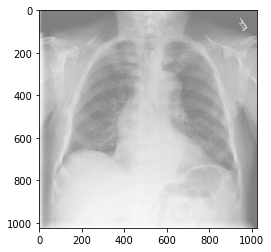

In [67]:
imshow(img_data[30])

In [87]:
import time

In [93]:
dataloders = {
    'train': img_loader
}

In [94]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        #for phase in ['train', 'val']:
        for phase in ['train']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [95]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

In [96]:
from torch.optim import lr_scheduler

In [97]:
model_ft.fc = torch.nn.Linear(num_ftrs, 2)
model_ft = model_ft.cuda()

criterion = torch.nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
